# Training a pretrained ResNet 34 model on a Cars Dataset and visualizing the layer activations using GRADCAM for a mislabeled images of our weakest class.

Importing necessary libraries

In [ ]:
import os
import time
import torch
from pathlib import Path
from PIL import Image
import PIL.Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython.display import Image
import copy
from sklearn.metrics import f1_score
from torchvision.utils import make_grid, save_image
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loading the data from google drive


In [ ]:
from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
drive.mount('/gdrive')
%cd /gdrive/MyDrive/gradcam_plus_plus-pytorch-master/
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

Mounted at /gdrive
/gdrive/MyDrive/gradcam_plus_plus-pytorch-master


Making a dictionary of class names with their respective numbers


In [ ]:
meta = loadmat('/gdrive/MyDrive/preprocessed Data/devkit/cars_meta.mat')
meta.keys()
type(meta['class_names']),meta['class_names'].shape
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
    classDict.update({classCount:c[0]})
    classCount = classCount + 1
print(classDict)

#Labels for training data
labelfile1 = loadmat('/gdrive/MyDrive/preprocessed Data/devkit/cars_train_annos.mat')
labelfile1.keys()
type(labelfile1['annotations']),labelfile1['annotations'].shape
type(labelfile1['annotations'][0][0]),labelfile1['annotations'][0][0].shape
labelfile1['annotations'][0][0]['bbox_x1'], labelfile1['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile1['annotations'][0][0]]

trainLabels = [[row.flat[0] for row in line] for line in labelfile1['annotations'][0]]

#Labels for testing data
labelfile2 = loadmat('/gdrive/MyDrive/preprocessed Data/devkit/cars_test_annos_withlabels')
labelfile2.keys()
type(labelfile2['annotations']),labelfile2['annotations'].shape
type(labelfile2['annotations'][0][0]),labelfile2['annotations'][0][0].shape
labelfile2['annotations'][0][0]['bbox_x1'], labelfile2['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile2['annotations'][0][0]]

testLabels = [[row.flat[0] for row in line] for line in labelfile2['annotations'][0]]

{1: 'AM General Hummer SUV 2000', 2: 'Acura RL Sedan 2012', 3: 'Acura TL Sedan 2012', 4: 'Acura TL Type-S 2008', 5: 'Acura TSX Sedan 2012', 6: 'Acura Integra Type R 2001', 7: 'Acura ZDX Hatchback 2012', 8: 'Aston Martin V8 Vantage Convertible 2012', 9: 'Aston Martin V8 Vantage Coupe 2012', 10: 'Aston Martin Virage Convertible 2012', 11: 'Aston Martin Virage Coupe 2012', 12: 'Audi RS 4 Convertible 2008', 13: 'Audi A5 Coupe 2012', 14: 'Audi TTS Coupe 2012', 15: 'Audi R8 Coupe 2012', 16: 'Audi V8 Sedan 1994', 17: 'Audi 100 Sedan 1994', 18: 'Audi 100 Wagon 1994', 19: 'Audi TT Hatchback 2011', 20: 'Audi S6 Sedan 2011', 21: 'Audi S5 Convertible 2012', 22: 'Audi S5 Coupe 2012', 23: 'Audi S4 Sedan 2012', 24: 'Audi S4 Sedan 2007', 25: 'Audi TT RS Coupe 2012', 26: 'BMW ActiveHybrid 5 Sedan 2012', 27: 'BMW 1 Series Convertible 2012', 28: 'BMW 1 Series Coupe 2012', 29: 'BMW 3 Series Sedan 2012', 30: 'BMW 3 Series Wagon 2012', 31: 'BMW 6 Series Convertible 2007', 32: 'BMW X5 SUV 2007', 33: 'BMW X6 

# Data Preprocessing

The Pytorch framework needs the data to be segregated in a certain way for it to work at its best. For pretrained ResNet 34 model to be used for classification, we need the data to be segregated in folders of different classes. We will have 196 folders for 196 classes. We will also crop the images using their bounding boxes because we don't have to do object detection but classfication.

In [ ]:
#Preprocessing training images
#Going from random training examples to training examples in folders according to their classes.
#Every image has a specific class. Each image is saved in the folder named after its class. There are total 196 folders.

#train and val percentage is 90% and 10%
percent = 0.9
for t in trainLabels:
    #getting the data
    x1 = t[0]
    y1 = t[1]
    x2 = t[2]
    y2 = t[3]
    class_number = t[4]
    filename = t[5]
    address = '/gdrive/MyDrive/data/train/' + filename
    class_name = classDict.get(class_number) + '/'
    if count < int(len(trainLabels)*percent):
        saveDir = '/gdrive/MyDrive/preprocessed Data/train/' + class_name
    else:
        saveDir = '/gdrive/MyDrive/preprocessed Data/val/' + class_name

    #cropping the image and saving it
    im = PIL.Image.open(address)
    region = im.crop((x1,y1,x2,y2))
    Path(saveDir).mkdir(parents = True, exist_ok = True)
    saveAddress = saveDir + filename
    region.save(saveAddress)

In [ ]:
#Preprocessing testing images
#Going from random testing examples to testing examples in folders according to their classes.
#Every image has a specific class. Each image is saved in the folder named after its class. There are total 196 folders.

for t in testLabels:
    #getting the data
    x1 = t[0]
    y1 = t[1]
    x2 = t[2]
    y2 = t[3]
    class_number = t[4]
    filename = t[5]
    address = '/gdrive/MyDrive/data/test/' + filename
    class_name = classDict.get(class_number) + '/'
    saveDir = '/gdrive/MyDrive/preprocessed Data/test/' + class_name

    #cropping the image and saving it
    im = PIL.Image.open(address)
    region = im.crop((x1,y1,x2,y2))
    Path(saveDir).mkdir(parents = True, exist_ok = True)
    saveAddress = saveDir + filename
    region.save(saveAddress)





Data Augmentation and Normalization for training

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


data_dir = '/gdrive/MyDrive/preprocessed Data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Function for training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step(loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Transfer Learning

Here we load the pretrained ResNet 34 model. We will freeze the earlier layers and only replace the last layer with a new one with randomly initialized weights. This is the layer that we will train. We are using the knowledge of the pretrained model which is trained on x number of images already. Because we have a small training set and we want better results, we are using Transfer Learning.

In [ ]:
model_conv = torchvision.models.resnet34(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

for i in range(0,3):
  for param in model_conv.layer4[i].parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = 512
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 196), nn.ReLU()) #196 output points because we have 196 classes

print(model_conv)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=0.01, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_conv, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Final Step

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)
model_save_name = 'classfier3Conv.pt'
path = F"/gdrive/MyDrive/{model_save_name}"
torch.save(model_conv.state_dict(), path)


Epoch 0/99
----------
train Loss: 5.2824 Acc: 0.0120
val Loss: 5.2874 Acc: 0.0061

Epoch 1/99
----------
train Loss: 5.0902 Acc: 0.0557
val Loss: 5.3485 Acc: 0.0147

Epoch 2/99
----------
train Loss: 4.8189 Acc: 0.1063
val Loss: 5.4192 Acc: 0.0123

Epoch 3/99
----------
train Loss: 4.5287 Acc: 0.1663
val Loss: 5.5064 Acc: 0.0208

Epoch 4/99
----------
train Loss: 4.2302 Acc: 0.2104
val Loss: 5.5567 Acc: 0.0294

Epoch 5/99
----------
train Loss: 3.9423 Acc: 0.2672
val Loss: 5.7460 Acc: 0.0319

Epoch 6/99
----------
train Loss: 3.6726 Acc: 0.3170
val Loss: 5.8045 Acc: 0.0331

Epoch 7/99
----------
train Loss: 3.4518 Acc: 0.3544
val Loss: 5.9271 Acc: 0.0355

Epoch 8/99
----------
train Loss: 3.2657 Acc: 0.3938
val Loss: 5.9636 Acc: 0.0355

Epoch 9/99
----------
train Loss: 3.0799 Acc: 0.4258
val Loss: 6.1638 Acc: 0.0380

Epoch 10/99
----------
train Loss: 2.8881 Acc: 0.4621
val Loss: 6.0934 Acc: 0.0380

Epoch 11/99
----------
train Loss: 2.7342 Acc: 0.4914
val Loss: 6.4109 Acc: 0.0404

Ep

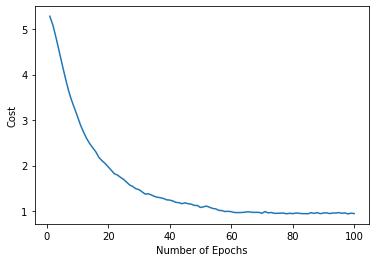

In [ ]:
x = [
      1, 2, 3, 4, 5, 6, 7, 8, 9,10,
     11,12,13,14,15,16,17,18,19,20,
     21,22,23,24,25,26,27,28,29,30,
     31,32,33,34,35,36,37,38,39,40,
     41,42,43,44,45,46,47,48,49,50,
     51,52,53,54,55,56,57,58,59,60,
     61,62,63,64,65,66,67,68,69,70,
     71,72,73,74,75,76,77,78,79,80,
     81,82,83,84,85,86,87,88,89,90,
     91,92,93,94,95,96,97,98,99,100
     ]
#training loss
y = [
     5.2824,5.0902,4.8189,4.5287,4.2302,
     3.9423,3.6726,3.4518,3.2657,3.0799,
     2.8881,2.7342,2.5935,2.4807,2.3884,
     2.2985,2.1772,2.1057,2.0463,1.9706,
     1.8975,1.8203,1.7923,1.7416,1.6960,
     1.6345,1.5717,1.5399,1.4900,1.4716,
     1.4236,1.3744,1.3795,1.3558,1.3225,
     1.3033,1.2926,1.2755,1.2464,1.2416,
     1.2222,1.1917,1.1838,1.1618,1.1817,
     1.1616,1.1520,1.1239,1.1231,1.0788,
     1.0939,1.1088,1.0827,1.0577,1.0468,
     1.0151,1.0104,0.9895,0.9947,0.9866,
     0.9686,0.9667,0.9676,0.9713,0.9823,
     0.9817,0.9714,0.9710,0.9720,0.9504,
     0.9893,0.9600,0.9684,0.9502,0.9508,
     0.9523,0.9563,0.9403,0.9513,0.9432,
     0.9561,0.9521,0.9435,0.9428,0.9407,
     0.9643,0.9481,0.9660,0.9422,0.9576,
     0.9617,0.9444,0.9573,0.9566,0.9660,
     0.9512,0.9595,0.9372,0.9536,0.9449
     ]


plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.plot(x,y)

Training Set Accuracy

In [ ]:
# Getting the dataloader ready
data_dir = '/gdrive/MyDrive/preprocessed Data/'
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train'])
trainDataloader = torch.utils.data.DataLoader(image_datasets, batch_size=256, shuffle=False, num_workers=2)

#Loading the trained model
model_conv = torchvision.models.resnet34(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 196), nn.ReLU())
model_conv = model_conv.to(device)
model_save_name = 'classfier3Conv.pt'
path = '/gdrive/MyDrive/' + model_save_name
model_conv.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# #Getting the labels and the generated outputs in separate tensors (labelTensorTest and outputTensorTest)
# labelsList = []
# outputsList = []

# for inputs, labels in trainDataloader:
#   inputs = inputs.to(device)
#   labels = labels.to(device)
#   outputs = model_conv(inputs)
#   _, preds = torch.max(outputs, 1)
#   labelsList.append(labels)
#   outputsList.append(preds)

# labelTensorTrain = labelsList[0]
# outputTensorTrain = outputsList[0]
# for i in range(1,len(labelsList)):
#   labelTensorTrain = torch.cat((labelTensorTrain, labelsList[i]))
#   outputTensorTrain = torch.cat((outputTensorTrain, outputsList[i]))

# #Saving those tensors
# model_save_name = 'labelTensorTrain.pt'
# path = '/gdrive/MyDrive/' + model_save_name
# torch.save(labelTensorTrain, path)
# model_save_name = 'outputTensorTrain.pt'
# path = '/gdrive/MyDrive/' + model_save_name
# torch.save(outputTensorTrain, path)

#Calculating accuracy using F1 Score
trainingSetAccuracy = f1_score(torch.load('/gdrive/MyDrive/labelTensorTrain.pt', map_location=torch.device('cpu')).numpy(),
                               torch.load('/gdrive/MyDrive/outputTensorTrain.pt', map_location=torch.device('cpu')).numpy(),
                               average=None).tolist()

torch.save(trainingSetAccuracy, '/gdrive/MyDrive/trainingSetAccuracy.pt')

print('Classwise Train Set F1 Score:')
print('[Class Name]'  + ' => ' + '(F1 Score)')
for i in range(1, len(trainingSetAccuracy) + 1):
  print('[' + classDict.get(i) + ']'  + ' => ' + '(' + str(trainingSetAccuracy[i-1]) + ')')

print('---------------------------------------------------------')
print('The class "' + classDict.get(trainingSetAccuracy.index(min(trainingSetAccuracy))) + '" has minimum training set accuracy, it\'s index is ' + str(trainingSetAccuracy.index(min(trainingSetAccuracy))))

Classwise Train Set F1 Score:
[Class Name] => (F1 Score)
[AM General Hummer SUV 2000] => (0.75)
[Acura RL Sedan 2012] => (0.43478260869565216)
[Acura TL Sedan 2012] => (0.43749999999999994)
[Acura TL Type-S 2008] => (0.0)
[Acura TSX Sedan 2012] => (0.7160493827160495)
[Acura Integra Type R 2001] => (0.42500000000000004)
[Acura ZDX Hatchback 2012] => (0.5945945945945946)
[Aston Martin V8 Vantage Convertible 2012] => (0.0)
[Aston Martin V8 Vantage Coupe 2012] => (0.5)
[Aston Martin Virage Convertible 2012] => (0.0)
[Aston Martin Virage Coupe 2012] => (0.5974025974025974)
[Audi RS 4 Convertible 2008] => (0.37681159420289856)
[Audi A5 Coupe 2012] => (0.5714285714285715)
[Audi TTS Coupe 2012] => (0.4761904761904762)
[Audi R8 Coupe 2012] => (0.5227272727272727)
[Audi V8 Sedan 1994] => (0.41791044776119407)
[Audi 100 Sedan 1994] => (0.43478260869565216)
[Audi 100 Wagon 1994] => (0.4444444444444444)
[Audi TT Hatchback 2011] => (0.5217391304347826)
[Audi S6 Sedan 2011] => (0.13513513513513511)


Test Set Accuracy

In [ ]:
# Getting the dataloader ready
data_dir = '/gdrive/MyDrive/preprocessed Data/'
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'),data_transforms['test'])
testDataloader = torch.utils.data.DataLoader(image_datasets, batch_size=256, shuffle=False, num_workers=2)

#Loading the trained model
model_conv = torchvision.models.resnet34(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 196), nn.ReLU())
model_conv = model_conv.to(device)
model_save_name = 'classfier3Conv.pt'
path = '/gdrive/MyDrive/' + model_save_name
model_conv.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# #Getting the labels and the generated outputs in separate tensors (labelTensorTest and outputTensorTest)
# labelsList = []
# outputsList = []

# for inputs, labels in testDataloader:
#   inputs = inputs.to(device)
#   labels = labels.to(device)
#   outputs = model_conv(inputs)
#   _, preds = torch.max(outputs, 1)
#   labelsList.append(labels)
#   outputsList.append(preds)

# labelTensorTest = labelsList[0]
# outputTensorTest = outputsList[0]
# for i in range(1,len(labelsList)):
#   labelTensorTest = torch.cat((labelTensorTest, labelsList[i]))
#   outputTensorTest = torch.cat((outputTensorTest, outputsList[i]))

# #Saving those tensors
# model_save_name = 'labelTensorTest.pt'
# path = '/gdrive/MyDrive/' + model_save_name
# torch.save(labelTensorTest, path)
# model_save_name = 'outputTensorTest.pt'
# path = '/gdrive/MyDrive/' + model_save_name
# torch.save(outputTensorTest, path)

#Calculating accuracy using F1 Score
testSetAccuracy = f1_score(torch.load('/gdrive/MyDrive/labelTensorTest.pt', map_location=torch.device('cpu')).numpy(),
                               torch.load('/gdrive/MyDrive/outputTensorTest.pt', map_location=torch.device('cpu')).numpy(),
                               average=None).tolist()

torch.save(testSetAccuracy, '/gdrive/MyDrive/testSetAccuracy.pt')

print('Classwise Test Set F1 Score:')
print('[Class Name]'  + ' => ' + '(F1 Score)')
for i in range(1, len(testSetAccuracy) + 1):
  print('[' + classDict.get(i) + ']'  + ' => ' + '(' + str(testSetAccuracy[i-1]) + ')')

print('---------------------------------------------------------')
print('The class "' + classDict.get(testSetAccuracy.index(min(testSetAccuracy))) + '" has minimum test set accuracy, it\'s index is ' + str(testSetAccuracy.index(min(testSetAccuracy))))


Classwise Test Set F1 Score:
[Class Name] => (F1 Score)
[AM General Hummer SUV 2000] => (0.09836065573770492)
[Acura RL Sedan 2012] => (0.14150943396226415)
[Acura TL Sedan 2012] => (0.0963855421686747)
[Acura TL Type-S 2008] => (0.0)
[Acura TSX Sedan 2012] => (0.20618556701030927)
[Acura Integra Type R 2001] => (0.13445378151260504)
[Acura ZDX Hatchback 2012] => (0.19047619047619047)
[Aston Martin V8 Vantage Convertible 2012] => (0.0)
[Aston Martin V8 Vantage Coupe 2012] => (0.07079646017699115)
[Aston Martin Virage Convertible 2012] => (0.0)
[Aston Martin Virage Coupe 2012] => (0.11594202898550723)
[Audi RS 4 Convertible 2008] => (0.07407407407407407)
[Audi A5 Coupe 2012] => (0.06593406593406594)
[Audi TTS Coupe 2012] => (0.10309278350515463)
[Audi R8 Coupe 2012] => (0.16666666666666666)
[Audi V8 Sedan 1994] => (0.1149425287356322)
[Audi 100 Sedan 1994] => (0.02)
[Audi 100 Wagon 1994] => (0.02531645569620253)
[Audi TT Hatchback 2011] => (0.060606060606060615)
[Audi S6 Sedan 2011] => 

Getting overall training and test accuracy

In [ ]:
model_save_name = 'classfier3Conv.pt'
path = '/gdrive/MyDrive/' + model_save_name
model_conv.load_state_dict(torch.load(path))

total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_conv(images)
        _, guess = torch.max(outputs.data, 1)
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(trainLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full train dataset fed: {round(100 * correct / total,8)}%")

Total images tested in model: 8144
Total accurate predictions: 5970
Accuracy of model w/ full train dataset fed: 81.46834061%


In [ ]:
# model_save_name = 'newClassifier.pt'
# path = '/gdrive/MyDrive/' + model_save_name
# model_conv.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_conv(images)
        _, guess = torch.max(outputs.data, 1)
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")

Total images tested in model: 8041
Total accurate predictions: 5480
Accuracy of model w/ full test dataset fed: 68.15072752%


#Analysing the weakest class using Grad-CAM

I created a separate dataset which will have the weakest classes. After seeing what the algorithm predicts, using Grad-CAM we would try to get insights as to why it predicted the wrong class.

In [ ]:
#Getting the dataloader ready
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#datasetOfWeakest only contains one class i.e. Acura TL Sedan 2012 (the weakest class)
data_dir = '/gdrive/MyDrive/datasetOfWeakest/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



#Getting predictions from the weakest class and see what we get
classNumberList = []
classList = []
for data in dataloaders['train']:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_conv(images)
    _, guess = torch.max(outputs, 1)
    for i in guess.tolist():
      classNumberList.append(i)
      classList.append(classDict.get(i))

print('The class with which the weakest class (Acura TL Sedan 2012) is most confused with (in training set) is: ' + max(set(classList), key = classList.count))

classNumberList = []
classList = []
for data in dataloaders['test']:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model_conv(images)
    _, guess = torch.max(outputs, 1)
    for i in guess.tolist():
      classNumberList.append(i)
      classList.append(classDict.get(i))

print('The class with which the weakest class (Acura TL Sedan 2012) is most confused with (in test set) is:     ' + max(set(classList), key = classList.count))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


The class with which the weakest class (Acura TL Sedan 2012) is most confused with (in training set) is: Acura TSX Sedan 2012
The class with which the weakest class (Acura TL Sedan 2012) is most confused with (in test set) is:     Acura RL Sedan 2012


Using GRADCAM for the mislabeled images of the weakest classes

In [ ]:
%cd /gdrive/MyDrive/gradcam_plus_plus-pytorch-master/
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

/gdrive/MyDrive/gradcam_plus_plus-pytorch-master


In [ ]:
model_save_name = 'classfier3Conv.pt'
path = '/gdrive/MyDrive/' + model_save_name
model_conv.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
resnet = model_conv
configs = [
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
]
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


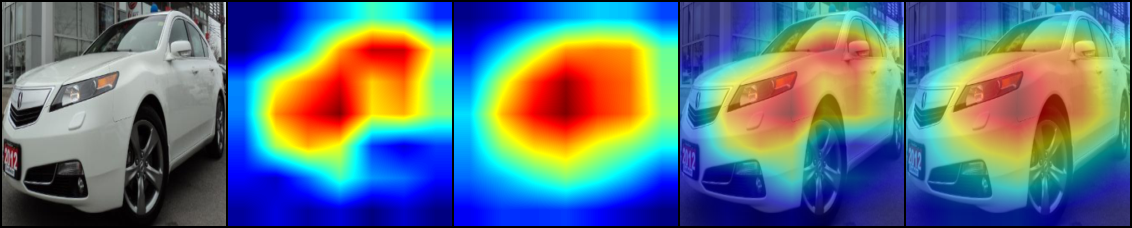

In [ ]:
img_dir = '/gdrive/MyDrive/preprocessed Data/train/Acura TL Sedan 2012/'
img_name = '02589.jpg'

img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)

torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

images = []
for gradcam, gradcam_pp in cams:
  mask, _ = gradcam(normed_torch_img)
  heatmap, result = visualize_cam(mask, torch_img)

  mask_pp, _ = gradcam_pp(normed_torch_img)
  heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

  images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)

transforms.ToPILImage()(grid_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


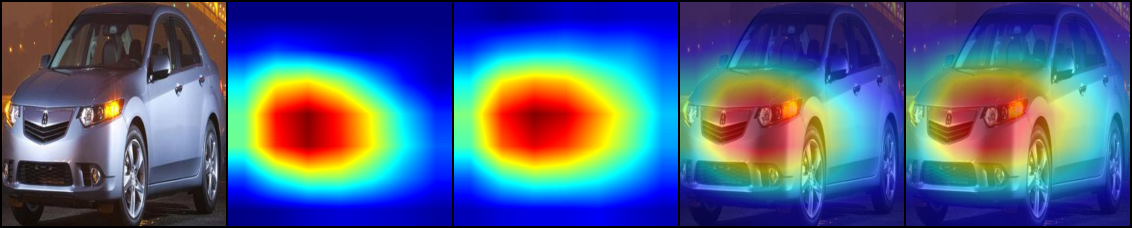

In [ ]:
img_dir = '/gdrive/MyDrive/preprocessed Data/train/Acura TSX Sedan 2012/'
img_name = '02004.jpg'

img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)

torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

images = []
for gradcam, gradcam_pp in cams:
  mask, _ = gradcam(normed_torch_img)
  heatmap, result = visualize_cam(mask, torch_img)

  mask_pp, _ = gradcam_pp(normed_torch_img)
  heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

  images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)

transforms.ToPILImage()(grid_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


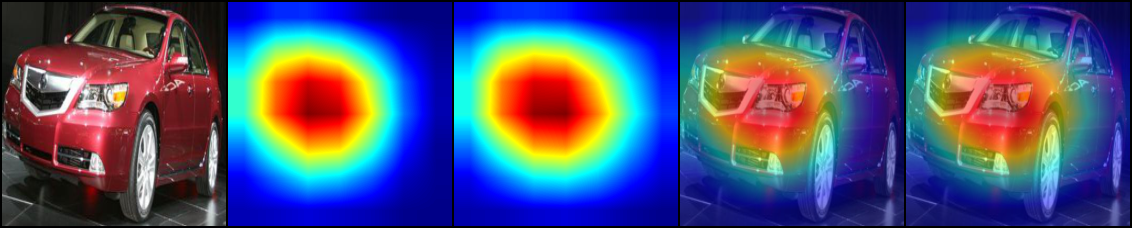

In [ ]:
img_dir = '/gdrive/MyDrive/preprocessed Data/train/Acura RL Sedan 2012/'
img_name = '02314.jpg'

img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)

torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

images = []
for gradcam, gradcam_pp in cams:
  mask, _ = gradcam(normed_torch_img)
  heatmap, result = visualize_cam(mask, torch_img)

  mask_pp, _ = gradcam_pp(normed_torch_img)
  heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

  images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)

transforms.ToPILImage()(grid_image)

This one was one of the weakest classes. When we use Grad-CAM, we can see that it is the headlight area which gets the most activated. The headlight area which helped to distinguish this car(Acura TL Sedan 2012) from others fails with the other two classes(Acura ZDX Hatchback 2012 and Acura RL Sedan 2012). The cars in these three classes are of the same company and they do look extremely similar, almost identical.

One solution here can be to combine these classes into one class. Because we are using a Residual network, we can only comprehend visual features. So training here is futile since the difference doesn't lie in the visual part.